In [1]:
import os
import numpy as np
import pandas as pd
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

warnings.filterwarnings('ignore')
os.makedirs('./csv', exist_ok=True)
os.makedirs('./figures', exist_ok=True)

## 1. Load Data

In [2]:
def extract_values(sentence, pattern):
    match = re.match(pattern, sentence) 
    if match:
        return match
    else:
        return None

In [6]:
def read_mnist_log(infile):
    m_pattern = r"~~~~Start training a new model with rho = (\d+\.\d+) iteration = (\d+) ~~~~"
    v_pattern = r"==>>> epoch: (\d+), test loss: (\d+\.\d+), acc: (\d+\.\d+)"

    vals_dict = {}
    with open(infile) as f:
        f = f.readlines()
        arr = [0.0] * 30
        prev_rho = 0
        rho = 0
        iteration = 0
        for line in f:
            m_result = extract_values(line, m_pattern)
            v_result = extract_values(line, v_pattern)
            if m_result:
                rho = float(m_result.group(1))
                if prev_rho != rho:
                    vals_dict[str(prev_rho)] = arr
                    arr = [0] * 30
                    prev_rho = rho
                iteration = int(m_result.group(2))
    #             print(f"rho: {rho}, iteration: {iteration}")
            elif v_result:
                val = float(v_result.group(3))
                arr[iteration-1] = max(arr[iteration-1], val)
        vals_dict[str(prev_rho)] = arr
        if '0' in vals_dict:
            del vals_dict['0']
    
    result = []
    for key in vals_dict:
        result.append([float(key)] + vals_dict[key])
    result = np.array(result)
    return result

In [7]:
# load by log
result_rho1 = read_mnist_log("./log/your_accuracy_log.log")
result_rho2 = read_mnist_log("./log/your_accuracy_log.log")

# or load from npy
# result_rho1 = np.load("./result/ffesn_accuracy_rho_iter.npy")
# result_rho2 = np.load("./result/ffesn_accuracy_rho_iter.npy")

arr = np.concatenate((result_rho1, result_rho2), axis=0)

In [9]:
headers = np.linspace(1, 30, 30).astype(int)
headers = list(map(str, headers))
rho_headers = ['rho'] + headers
df = pd.DataFrame(arr, columns=rho_headers)

In [10]:
df.head(91)

,rho,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.1,0.924,0.920,0.591,0.291,0.184,0.101,0.098,0.102,0.142,...,0.104,0.092,0.089,0.087,0.105,0.113,0.085,0.075,0.110,0.084
1,0.1,0.924,0.920,0.559,0.322,0.151,0.128,0.065,0.101,0.051,...,0.078,0.128,0.118,0.122,0.110,0.112,0.122,0.082,0.099,0.112
2,0.1,0.924,0.919,0.608,0.356,0.122,0.076,0.131,0.109,0.101,...,0.108,0.121,0.115,0.073,0.099,0.076,0.085,0.109,0.115,0.103
3,0.1,0.924,0.919,0.600,0.330,0.123,0.091,0.092,0.098,0.118,...,0.133,0.092,0.111,0.109,0.072,0.096,0.112,0.108,0.092,0.091
4,0.1,0.924,0.920,0.611,0.282,0.123,0.118,0.104,0.101,0.099,...,0.096,0.085,0.082,0.117,0.113,0.118,0.082,0.116,0.091,0.104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1.6,0.983,0.983,0.982,0.981,0.981,0.981,0.979,0.980,0.980,...,0.973,0.976,0.977,0.973,0.974,0.971,0.968,0.974,0.973,0.969
87,1.7,0.982,0.982,0.982,0.982,0.980,0.980,0.979,0.979,0.979,...,0.964,0.965,0.967,0.968,0.964,0.967,0.963,0.955,0.961,0.956
88,1.8,0.982,0.983,0.981,0.980,0.981,0.980,0.981,0.979,0.978,...,0.962,0.962,0.961,0.959,0.959,0.954,0.958,0.951,0.938,0.940
89,1.9,0.983,0.981,0.982,0.980,0.978,0.980,0.978,0.976,0.978,...,0.957,0.948,0.957,0.952,0.930,0.934,0.919,0.923,0.938,0.921


## 2. Average Accuracy

In [12]:
avg_accuracy = []
rhos = [round(0.1 * i, 2) for i in range(1, 21)]
sp_range = list(map(str, rhos))

for rho in rhos:
    mask = (df['rho'] == rho)
    row = df[mask].to_numpy()[:,1:]
    size = len(row)
    avg = row.sum(axis=0)/size
    avg_accuracy.append(avg)
    
avg_accuracy = np.array(avg_accuracy)
avg_df = pd.DataFrame(avg_accuracy, columns=headers)
avg_df = avg_df.rename(index=lambda s: sp_range[s])
avg_df.head(20)

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0.1,0.92400,0.91960,0.59380,0.31620,0.14060,0.10280,0.09800,0.10220,0.10220,0.10260,...,0.10380,0.10360,0.10300,0.10160,0.09980,0.10300,0.09720,0.09800,0.10140,0.09880
0.2,0.93320,0.92340,0.91520,0.80780,0.28320,0.34100,0.11040,0.10540,0.08960,0.08780,...,0.09320,0.11440,0.10760,0.09360,0.09600,0.09800,0.09780,0.10960,0.08040,0.08760
0.3,0.96180,0.93860,0.93740,0.91360,0.87840,0.37380,0.29000,0.25580,0.15500,0.13300,...,0.10120,0.08180,0.10540,0.10740,0.11160,0.09360,0.10040,0.09720,0.10960,0.11320
0.4,0.97460,0.96200,0.95680,0.93300,0.92120,0.90720,0.77980,0.37620,0.28400,0.25660,...,0.09600,0.10840,0.10940,0.10920,0.09820,0.10740,0.08420,0.11540,0.11140,0.09720
0.5,0.97640,0.97160,0.96580,0.94700,0.94200,0.92860,0.92080,0.89720,0.78780,0.53940,...,0.11040,0.08260,0.10960,0.09940,0.09040,0.08500,0.10860,0.07720,0.10820,0.09720
0.6,0.97900,0.97820,0.97280,0.97200,0.96980,0.95980,0.94340,0.93180,0.93140,0.91060,...,0.10020,0.13480,0.10180,0.12300,0.08820,0.08660,0.09620,0.09880,0.10140,0.08520
0.7,0.97960,0.97720,0.97800,0.97520,0.97200,0.97380,0.96800,0.95800,0.95920,0.94940,...,0.34220,0.29100,0.30860,0.24860,0.22040,0.22640,0.14500,0.18500,0.12300,0.09740
0.8,0.98020,0.97920,0.98020,0.97880,0.97800,0.97800,0.97460,0.97680,0.97560,0.97340,...,0.92880,0.90720,0.90400,0.89280,0.73620,0.64660,0.59720,0.47280,0.47860,0.45380
0.9,0.98120,0.98100,0.98080,0.97900,0.97860,0.97980,0.97980,0.98000,0.97880,0.97880,...,0.97180,0.97300,0.97060,0.97320,0.96840,0.96400,0.96480,0.96340,0.96060,0.95340
1.0,0.98060,0.98140,0.98100,0.98060,0.98060,0.98060,0.98080,0.98000,0.98060,0.98000,...,0.98140,0.98100,0.98080,0.98080,0.98060,0.97980,0.98100,0.98100,0.97940,0.98100


In [ ]:
avg_accuracy.to_csv('./csv/avg_accuracy.csv', index=False)

## 3. Plot Heat Map

### MLEs

In [13]:
# ESN: rho: 0.1 - 0.9

# MLE = [
#     -2.302581701396591,
#     -1.6094371827233587,
#     -1.2039758364146724,
#     -0.9162924561160241,
#     -0.6931497208060942,
#     -0.5108280890009538,
#     -0.3566761772823276,
#     -0.2231402806897289,
#     -0.10535861580217339,
# ]

# up = [
#     -2.3025631,
#     -1.60941641,
#     -1.20395089,
#     -0.91626954,
#     -0.69312522,
#     -0.51080389,
#     -0.35665302,
#     -0.22312162,
#     -0.10533876,
# ]

# low = [
#     -2.30260694,
#     -1.6094594,
#     -1.20399457,
#     -0.9163127,
#     -0.69316919,
#     -0.5108471,
#     -0.35669702,
#     -0.22316577,
#     -0.10538243,
# ]

# MLE = np.array(MLE)
# up = np.array(up)
# low = np.array(low)
# lyapunov_time = -1/MLE
# lt_up = -1/up
# lt_low = -1/low
# print(lyapunov_time)

# nclyapunov_time_df = pd.DataFrame.from_dict({"Spectral Radius": [], "Iteration Time": [],
#                                           "It low": [], "It up": []})
# for i in range(len(lyapunov_time)-1, -1, -1):
#     nclyapunov_time_df = nclyapunov_time_df.append(
#         pd.Series([sp_range[i], lyapunov_time[i],
#                    lt_up[i], lt_low[i]], index=nclyapunov_time_df.columns), ignore_index=True)

[0.43429512 0.62133522 0.83058145 1.09135461 1.44268975 1.95760574
 2.80366356 4.4814858  9.49139273]


In [14]:
MLE = [
    0.00000262136421636458,
    0.00007262136421636458,
    0.0056225977572091825,
    0.02470505628828376,
    0.043734381049623856,
    0.06154031680004396,
    0.0793002624204618,
    0.09706150983000186,
    0.11409762048664748,
    0.13141171988583142,
    0.14834939869695293
]

up = [
    0.0000023617151,
    0.0000723617151,
    0.00630528651,
    0.0265401992,
    0.0452782870,
    0.0629591343,
    0.0810150521,
    0.0986482193,
    0.116342183,
    0.133316844,
    0.150305281
]

low = [
    0.0000020315857,
    0.0000720315857,
    0.00574532,
    0.0237654,
    0.04136248,
    0.05884805,
    0.07784598,
    0.0950544,
    0.1126091,
    0.13021346,
    0.14678409
]

MLE = np.array(MLE)
up = np.array(up)
low = np.array(low)
lyapunov_time = 1/MLE
lt_up = 1/up
lt_low = 1/low
print(lyapunov_time)

lyapunov_time_df = pd.DataFrame.from_dict({"Spectral Radius": [], "Iteration Time": [],
                                          "It low": [], "It up": []})
for i in range(len(lyapunov_time)-1, -1, -1):
    lyapunov_time_df = lyapunov_time_df.append(
        pd.Series([sp_range[i+9], lyapunov_time[i],
                   lt_up[i], lt_low[i]], index=lyapunov_time_df.columns), ignore_index=True)
lyapunov_time_df.head(11)

[3.81480755e+05 1.37700525e+04 1.77853733e+02 4.04775439e+01
 2.28653059e+01 1.62495101e+01 1.26102987e+01 1.03027452e+01
 8.76442467e+00 7.60967135e+00 6.74084296e+00]


,Spectral Radius,Iteration Time,It low,It up
0,2.0,6.740843,6.653126,6.812727
1,1.9,7.609671,7.500928,7.679698
2,1.8,8.764425,8.595335,8.880277
3,1.7,10.302745,10.137030,10.520292
4,1.6,12.610299,12.343385,12.845878
5,1.5,16.249510,15.883319,16.992917
6,1.4,22.865306,22.085641,24.176500
7,1.3,40.477544,37.678692,42.077979
8,1.2,177.853733,158.597075,174.054709
9,1.1,13770.052529,13819.462386,13882.798640


### 3.2 Plot Heat Map

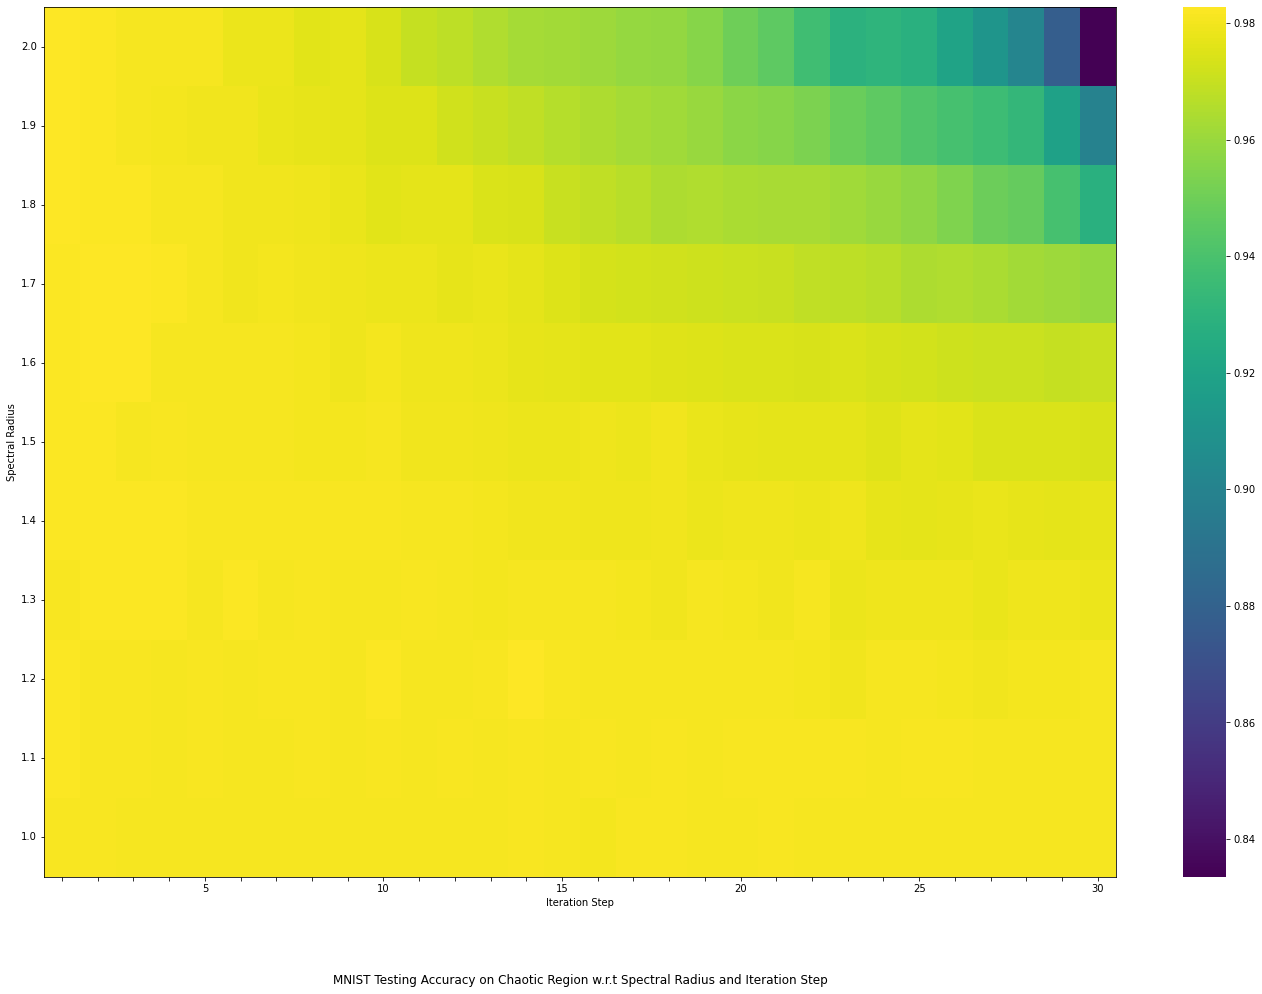

In [15]:
avg_df = pd.read_csv('./csv/avg_accuracy.csv')
avg_df = avg_df.set_index(avg_df.columns[0])
cesn_accuracy_df = avg_df.iloc[::-1].iloc[:11]
fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(1, 1, 1)
ax_twin = ax.twinx()

g2 = sns.heatmap(cesn_accuracy_df, cmap='viridis', xticklabels=True, yticklabels=True, ax=ax)

for item in g2.get_xticklabels():
    item.set_rotation(0)
for item in g2.get_yticklabels():
    item.set_rotation(0)

for ind, label in enumerate(g2.get_xticklabels()):
    if (ind + 1) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

# g3 = sns.lineplot(lyapunov_time_df, x="Iteration Time", y="Spectral Radius",
#                   marker='o', linestyle='-', linewidth=5)
ax_twin.get_yaxis().set_ticks([])
ax_twin.set_yticklabels([])
ax_twin.set(ylabel=None)
g2.set(xlabel="Iteration Step", ylabel="Spectral Radius")        
plt.title("MNIST Testing Accuracy on Chaotic Region w.r.t Spectral Radius and Iteration Step", y=-0.13)

plt.show()

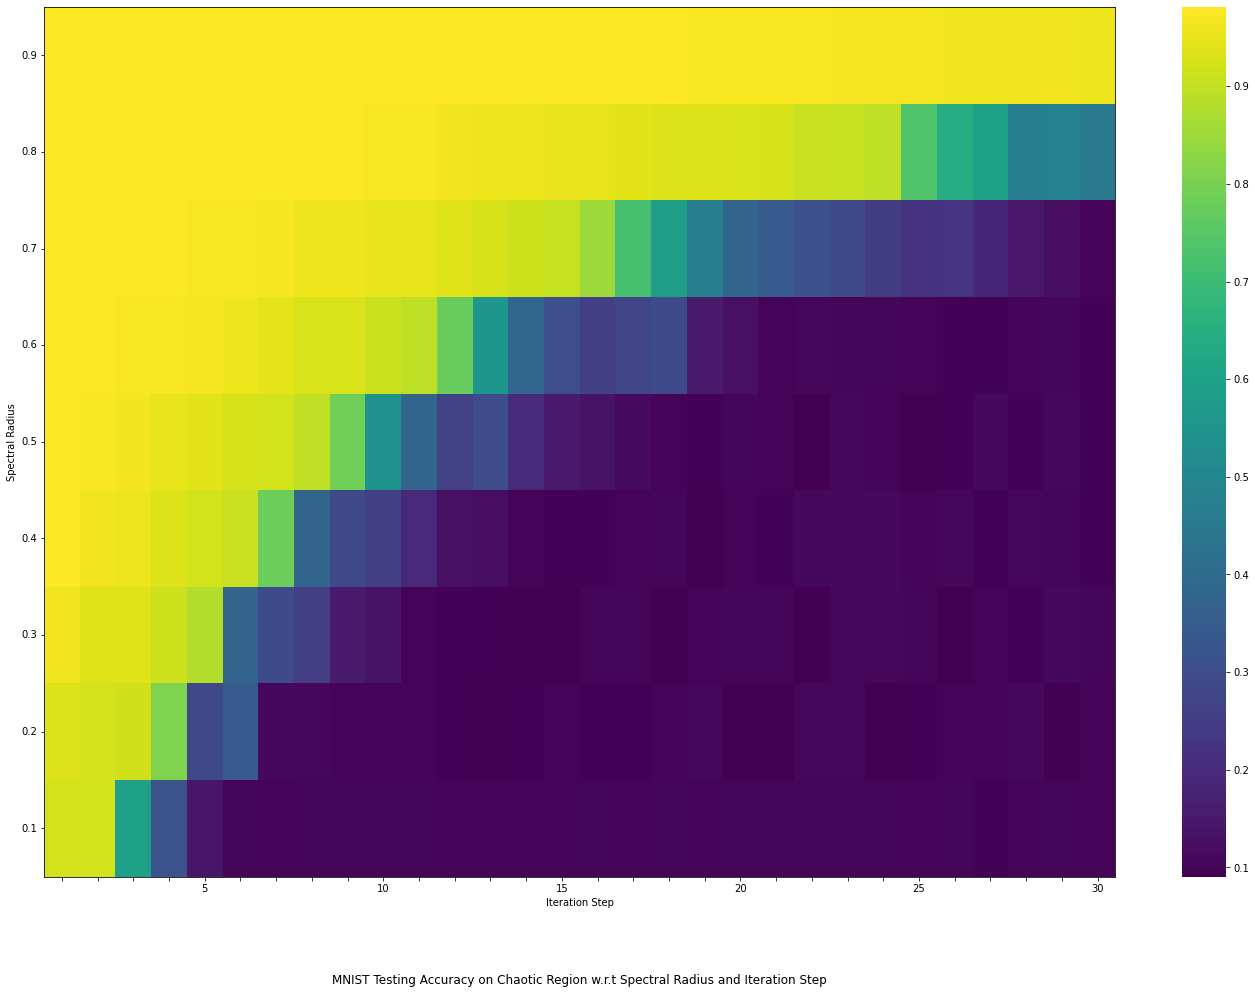

In [161]:
avg_df = pd.read_csv('./csv/avg_accuracy.csv')
avg_df = avg_df.set_index(avg_df.columns[0])
ncesn_accuracy_df = avg_df.iloc[::-1].iloc[11:]
fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(1, 1, 1)
ax_twin = ax.twinx()

g2 = sns.heatmap(ncesn_accuracy_df, cmap='viridis', xticklabels=True, yticklabels=True, ax=ax)

for item in g2.get_xticklabels():
    item.set_rotation(0)
for item in g2.get_yticklabels():
    item.set_rotation(0)

for ind, label in enumerate(g2.get_xticklabels()):
    if (ind + 1) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

# g3 = sns.lineplot(lyapunov_time_df, x="Iteration Time", y="Spectral Radius",
#                   marker='o', linestyle='-', linewidth=5)
ax_twin.get_yaxis().set_ticks([])
ax_twin.set_yticklabels([])
ax_twin.set(ylabel=None)
g2.set(xlabel="Iteration Step", ylabel="Spectral Radius")        
plt.title("MNIST Testing Accuracy on Chaotic Region w.r.t Spectral Radius and Iteration Step", y=-0.13)

plt.show()

### 3.3. Plot Log Error

In [16]:
esn_error_df = -np.log(1 - avg_df.iloc[::-1])
esn_error_df.head(20)

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,,,,,,,,,,,,,,,,,,,,,
2.0,4.031370,4.003590,3.950244,3.937341,3.937341,3.839702,3.839702,3.729701,3.761450,3.640089,...,2.918771,2.764621,2.645075,2.666429,2.638058,2.528859,2.424753,2.315164,2.099644,1.792760
1.9,4.031370,4.017384,3.963316,3.924602,3.887330,3.887330,3.805413,3.772261,3.750755,3.688879,...,3.112266,3.062941,2.966173,2.909555,2.838729,2.788718,2.744974,2.694147,2.513306,2.292635
1.8,4.045554,4.017384,4.017384,3.963316,3.937341,3.887330,3.899600,3.875209,3.805413,3.740173,...,3.310443,3.296837,3.250625,3.206453,3.152386,3.079114,2.980844,2.946942,2.788718,2.631089
1.7,4.003590,4.031370,4.031370,4.003590,3.950244,3.899600,3.912023,3.887330,3.875209,3.839702,...,3.506558,3.465736,3.434237,3.411248,3.331205,3.345290,3.324236,3.270169,3.237804,3.194183
1.6,4.017384,4.059943,4.031370,3.963316,3.937341,3.950244,3.937341,3.912023,3.875209,3.912023,...,3.669077,3.640089,3.659321,3.611918,3.593569,3.549118,3.540459,3.531876,3.499913,3.514926
1.5,4.003590,4.003590,3.963316,3.989985,3.937341,3.937341,3.937341,3.912023,3.924602,3.937341,...,3.763603,3.761450,3.761450,3.719339,3.761450,3.740173,3.659321,3.659321,3.669077,3.649659
1.4,4.017384,4.003590,4.017384,4.017384,3.976562,3.976562,3.989985,3.976562,3.976562,3.976562,...,3.863233,3.839702,3.851398,3.783190,3.761450,3.783190,3.805413,3.772261,3.761450,3.772261
1.3,3.976562,4.003590,4.003590,4.003590,3.963316,4.017384,3.963316,3.976562,3.963316,3.937341,...,3.899600,3.937341,3.839702,3.851398,3.851398,3.851398,3.816713,3.863233,3.851398,3.839702
1.2,4.003590,3.989985,3.989985,3.950244,3.989985,3.963316,3.976562,3.989985,3.963316,4.003590,...,3.950244,3.924602,3.899600,3.937341,3.950244,3.924602,3.899600,3.924602,3.924602,3.937341


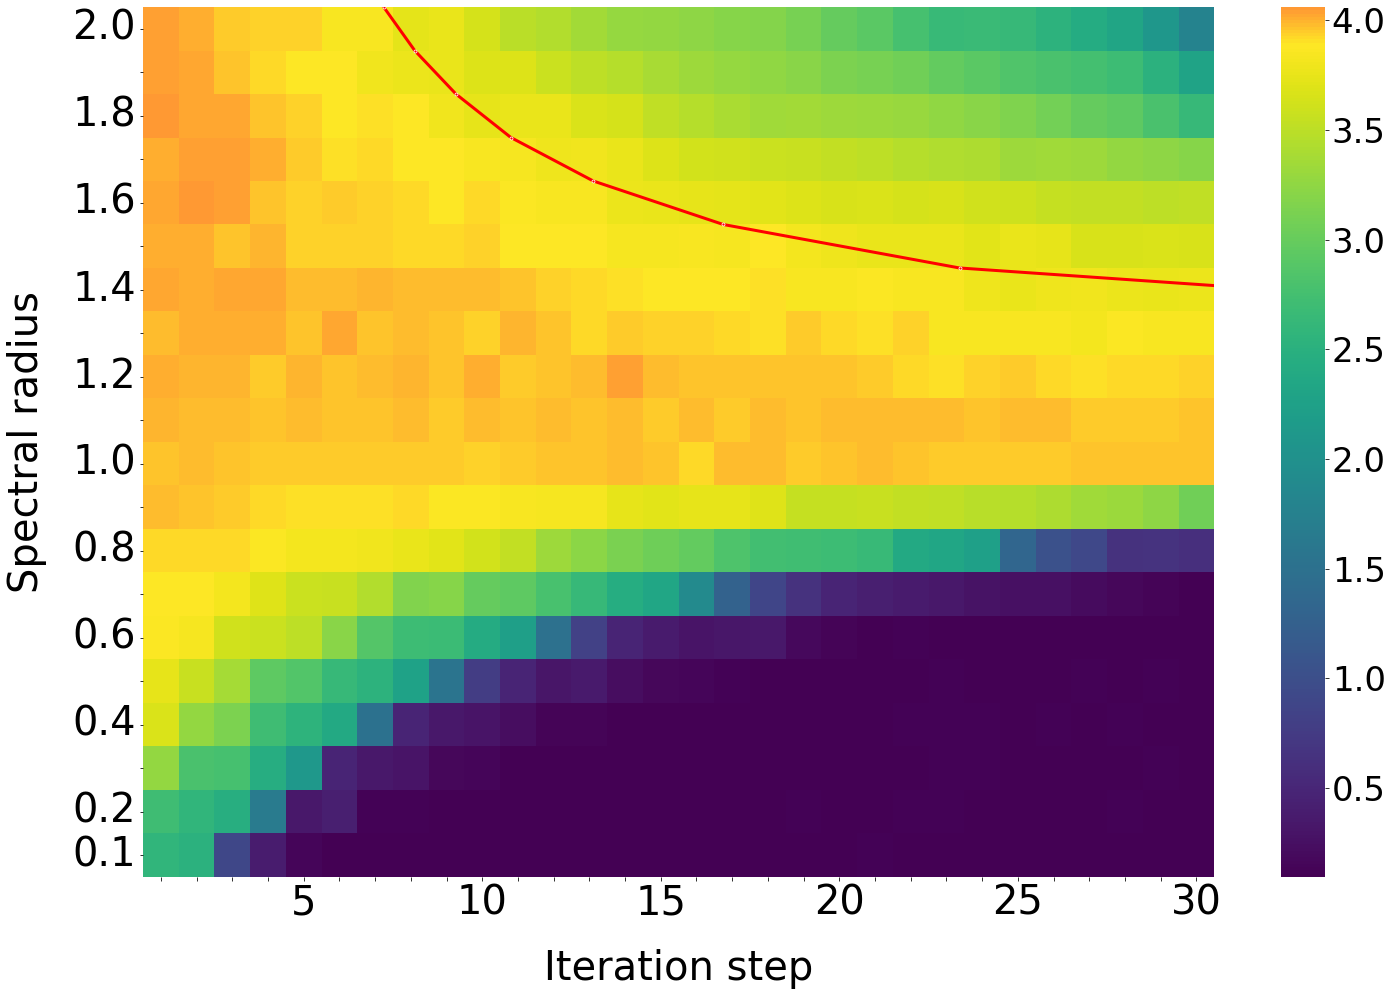

In [24]:
plt.rcParams.update({'font.size': 20})
diverging_colors = sns.diverging_palette(220, 20, as_cmap=True)
fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(1, 1, 1)

viridis_colors = plt.cm.viridis(np.linspace(0, 1, 256))
light_orange = np.array([1, 0.6, 0.2, 1])


n_extend = 12  # number of colors to interpolate
extended_colors = np.vstack([viridis_colors, 
                             np.array([np.linspace(viridis_colors[-1][i], light_orange[i], n_extend) for i in range(4)]).T])
extended_viridis = ListedColormap(extended_colors)

g1 = sns.heatmap(esn_error_df, cmap=extended_viridis, xticklabels=True, yticklabels=True, ax=ax)
plt.xticks(rotation=0) 
# ax_twin = ax.twinx()

for item in g1.get_xticklabels():
    item.set_rotation(0)
for item in g1.get_yticklabels():
    item.set_rotation(0)

for ind, label in enumerate(g1.get_xticklabels()):
    if (ind + 1) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
for ind, label in enumerate(g1.get_yticklabels()):
    if (ind) % 2 == 0 or ind==19:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
g3 = sns.lineplot(data=lyapunov_time_df, x="Iteration Time", y="Spectral Radius",
                  marker="o", linestyle="-", linewidth=3, markersize=3, color="red")

# lyapunov_time = lyapunov_time[::-1]
# for _ in range(9):
#     lyapunov_time = np.append(lyapunov_time, lyapunov_time[-1]*10)

# x = sp_range[::-1]
# for i in range(len(x)):
#     x[i] = x[i] 

# ax_twin.plot(lyapunov_time, x, marker='o', linestyle='-')
        
g3.set_xlabel("Iteration step", fontsize=40, labelpad=25)
g3.set_ylabel("Spectral radius", fontsize=40, labelpad=25)
g3.tick_params(axis='both', labelsize=40)
cbar = g3.collections[0].colorbar
cbar.ax.tick_params(labelsize=34)
# plt.title("MNIST Testing Error w.r.t Spectral Radius and Iteration Step", y=-0.12)
# plt.show()
plt.savefig("./figures/MNIST_accuracy.eps", format="eps", transparent=True)

In [133]:
lyapunov_time_df

,Spectral Radius,Iteration Time,It low,It up
0,2.0,6.740843,6.653126,6.812727
1,1.9,7.609671,7.500928,7.679698
2,1.8,8.764425,8.595335,8.880277
3,1.7,10.302745,10.137030,10.520292
4,1.6,12.610299,12.343385,12.845878
5,1.5,16.249510,15.883319,16.992917
6,1.4,22.865306,22.085641,24.176500
7,1.3,40.477544,37.678692,42.077979
8,1.2,177.853733,158.597075,174.054709
9,1.1,13770.052529,13819.462386,13882.798640


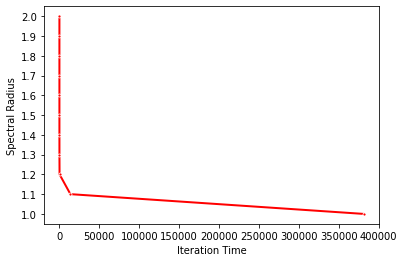

In [137]:
g3 = sns.lineplot(data=lyapunov_time_df, x="Iteration Time", y="Spectral Radius",
                  marker="o", linestyle="-", linewidth=2, markersize=3, color="red")


## 4. Training Loss vs Epoch

In [102]:
def read_loss(infile):
    m_pattern = r"~~~~Start training a new model with rho = (\d+\.\d+) iteration = (\d+) ~~~~"
    v_pattern = r"==>>> epoch: (\d+), test loss: (\d+\.\d+), acc: (\d+\.\d+)"

    result = np.zeros((20, 30, 2))
    with open(infile) as f:
        f = f.readlines()
        losses = [float('inf')] * 50
        rho = 0
        iteration = 0
        
        for line in f:
            m_result = extract_values(line, m_pattern)
            v_result = extract_values(line, v_pattern)
            if m_result:
                if rho != 0 and iteration != 0:
                    min_loss = min(losses)
                    threshold = min_loss * (1.05) # change this value.
                    idx = 50
                    for i, val in enumerate(losses):
                        if val <= threshold:
                            idx = i
                    result[int(rho*10)-1][iteration-1][0] = min_loss
                    result[int(rho*10)-1][iteration-1][1] = idx+1
                losses = [float('inf')] * 50
                rho = float(m_result.group(1))      
                iteration = int(m_result.group(2))
            elif v_result:
                epoch = int(v_result.group(1))
                val = float(v_result.group(2))
                losses[epoch-1] = val
    return result

In [103]:
# load by log
result_rho1 = read_loss("./log/your_loss_log.log")
result_rho2 = read_loss("./log/your_loss_log.log")

# or load from npy
# result_rho1 = np.load("./result/ffesn_loss_rho_iter.npy")
# result_rho2 = np.load("./result/ffesn_loss_rho_iter.npy")

total_loss = np.concatenate((result_rho1, result_rho2), axis=0)

In [104]:
avg_epoch = total_loss[:,:,1] / 5 # number of trial
avg_epoch[np.isnan(avg_epoch)] = 80 # max training epoch
print(avg_epoch)

[[35.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.
  50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.
  50.   50.   50.   50.   50.   50.  ]
 [20.6  15.4  35.4  50.   50.   50.   15.4  50.   50.   50.   50.   50.
  50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.
  50.   50.   50.   50.   50.   50.  ]
 [30.   16.6  32.6  28.6  50.   50.   50.   49.   29.6  37.8  50.   50.
  50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.
  50.   50.   50.   50.   50.   50.  ]
 [39.8  24.4  33.2  23.   30.6  47.8  50.   50.   50.   50.   17.8  27.2
  39.8  50.   50.   50.   50.   50.   50.   50.   50.   50.   50.   50.
  50.   50.   50.   50.   50.   50.  ]
 [32.   28.6  24.8  20.2  22.8  26.4  38.8  48.8  50.   50.   50.   50.
  50.   31.6  40.8  22.4  26.4  42.   50.   50.   50.   50.   50.   50.
  50.   50.   50.   50.   50.   50.  ]
 [35.6  38.6  27.4  34.4  37.8  30.8  25.2  22.6  40.6  45.   50.   50.
  50.   50. 

In [105]:
avg_epoch_df = pd.DataFrame(avg_epoch, columns = headers)
avg_epoch_df['rho'] = rhos
avg_epoch_df = avg_epoch_df.set_index(avg_epoch_df.columns[30])
avg_epoch_df = avg_epoch_df.iloc[::-1]
avg_epoch_df

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
rho,,,,,,,,,,,,,,,,,,,,,
2.0,39.50,34.50,34.50,39.50,30.50,34.00,45.00,37.50,47.00,38.00,...,18.50,13.50,11.50,18.25,11.00,14.50,11.50,16.50,8.25,50.00
1.9,35.75,44.00,39.75,41.00,33.75,36.50,39.25,44.00,42.50,33.75,...,16.75,23.50,11.50,16.00,15.25,14.00,11.00,20.25,21.50,16.00
1.8,43.75,36.25,40.25,33.75,42.50,40.75,33.75,44.00,41.50,38.25,...,31.25,19.00,27.00,23.50,17.00,14.75,28.25,17.75,16.25,14.50
1.7,39.75,37.25,40.25,42.25,29.50,43.25,36.00,43.25,37.50,39.75,...,28.25,22.75,19.25,21.25,16.75,21.00,22.00,22.25,21.00,19.00
1.6,32.25,46.00,44.00,40.25,40.25,40.00,44.50,42.25,39.75,39.00,...,32.00,31.75,30.75,32.00,24.25,28.75,25.00,31.75,26.75,26.25
1.5,36.50,34.75,39.25,40.00,34.50,43.00,44.75,30.25,38.75,38.50,...,34.75,47.25,36.25,31.00,43.50,36.50,37.50,36.50,37.00,29.75
1.4,47.00,42.00,43.50,38.00,35.75,49.25,40.50,38.50,36.50,46.75,...,33.75,45.50,40.75,32.75,40.50,39.00,35.75,47.25,43.25,40.00
1.3,39.50,38.75,42.75,41.00,41.00,42.25,40.75,46.25,39.25,31.25,...,35.50,35.50,34.00,39.75,40.00,40.25,35.00,35.00,42.75,35.75
1.2,37.25,35.25,37.00,28.25,40.50,40.00,49.00,39.00,44.25,37.00,...,36.50,35.25,40.50,42.00,38.75,34.00,40.00,35.50,39.25,39.25


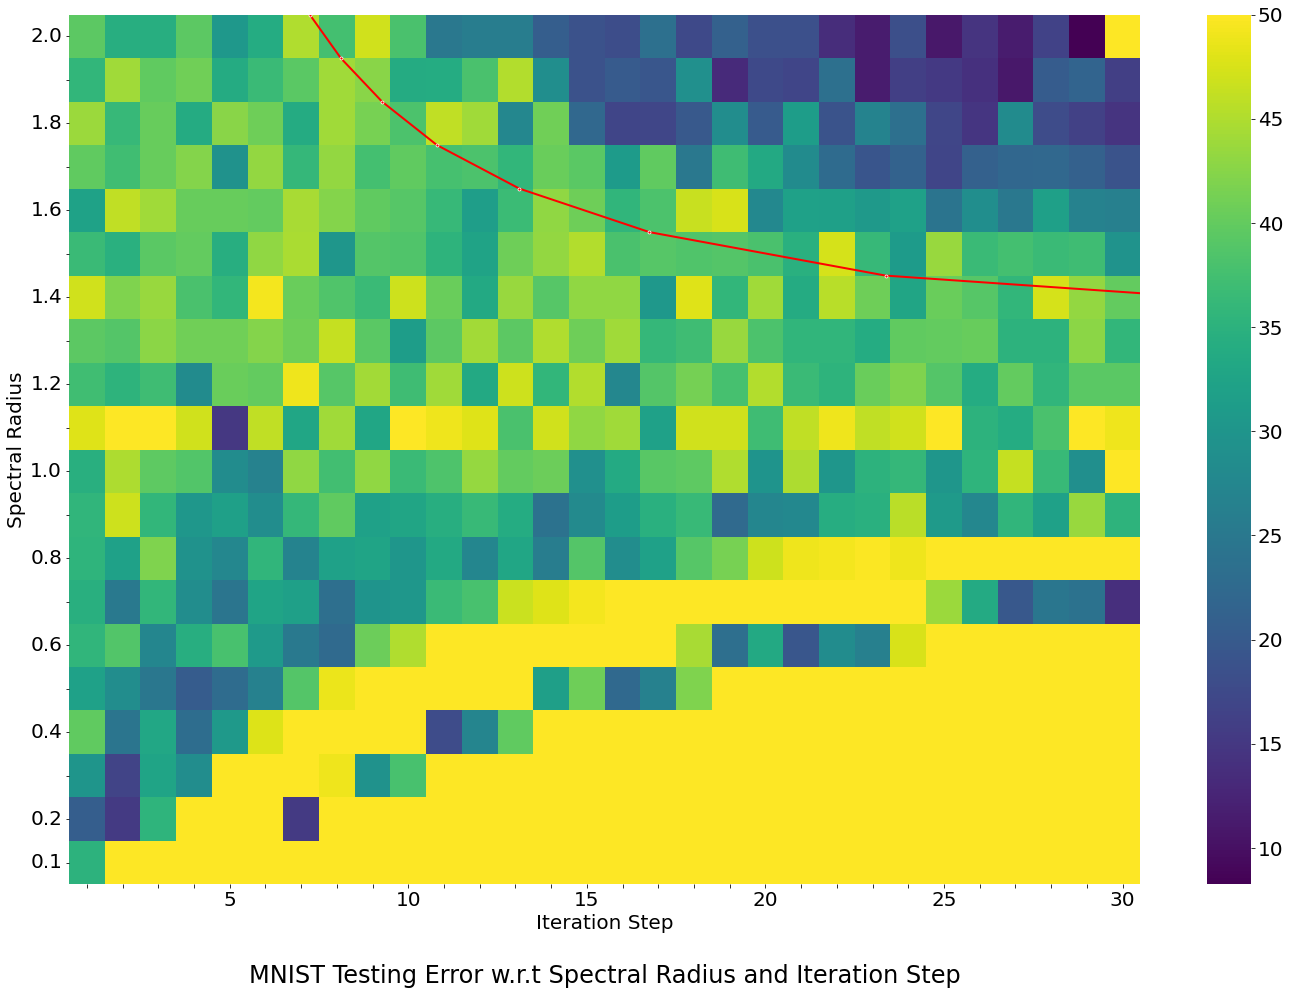

In [106]:
maptype = 'viridis'
plt.rcParams.update({'font.size': 20})
diverging_colors = sns.diverging_palette(220, 20, as_cmap=True)
fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(1, 1, 1)
g1 = sns.heatmap(avg_epoch_df, cmap='viridis', xticklabels=True, yticklabels=True, ax=ax)
plt.xticks(rotation=0) 
# ax_twin = ax.twinx()

for item in g1.get_xticklabels():
    item.set_rotation(0)
for item in g1.get_yticklabels():
    item.set_rotation(0)

for ind, label in enumerate(g1.get_xticklabels()):
    if (ind + 1) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
for ind, label in enumerate(g1.get_yticklabels()):
    if (ind) % 2 == 0 or ind==19:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
g3 = sns.lineplot(data=lyapunov_time_df, x="Iteration Time", y="Spectral Radius",
                  marker="o", linestyle="-", linewidth=2, markersize=3, color="red")

# lyapunov_time = lyapunov_time[::-1]
# for _ in range(9):
#     lyapunov_time = np.append(lyapunov_time, lyapunov_time[-1]*10)

# x = sp_range[::-1]
# for i in range(len(x)):
#     x[i] = x[i] 

# ax_twin.plot(lyapunov_time, x, marker='o', linestyle='-')
        
g1.set(xlabel="Iteration Step", ylabel="Spectral Radius")        
plt.title("MNIST Testing Error w.r.t Spectral Radius and Iteration Step", y=-0.12)
plt.show()

## 5. Training Accuracy vs Epoch

In [25]:
def read_accuracy(infile):
    m_pattern = r"~~~~Start training a new model with rho = (\d+\.\d+) iteration = (\d+) ~~~~"
    v_pattern = r"==>>> epoch: (\d+), test loss: (\d+\.\d+), acc: (\d+\.\d+)"

    result = np.zeros((20, 30, 2))
    count = np.zeros((20, 30))
    with open(infile) as f:
        f = f.readlines()
        accuracy = [0] * 50
        rho = 0
        iteration = 0
        
        for line in f:
            m_result = extract_values(line, m_pattern)
            v_result = extract_values(line, v_pattern)
            if m_result:
                if rho != 0 and iteration != 0:
                    max_accur = max(accuracy)
                    threshold = max_accur - 0.001 # change this value.
                    idx = 50
                    for i, val in enumerate(accuracy):
                        if val >= threshold:
                            idx = i
                    result[int(rho*10)-1][iteration-1][0] += max_accur
                    result[int(rho*10)-1][iteration-1][1] += idx+1
                    count[int(rho*10)-1][iteration-1] += 1
                accuracy = [0] * 50
                rho = float(m_result.group(1))      
                iteration = int(m_result.group(2))
            elif v_result:
                epoch = int(v_result.group(1))
                loss = float(v_result.group(2))
                acc = float(v_result.group(3))
                accuracy[epoch-1] = acc
    return result, count

In [8]:
loss0, count0 = read_accuracy(f"./log/your_accuracy_log.log")
loss1, count1 = read_accuracy(f"./log/your_accuracy_log.log")

count = count0 + count1
total_loss = loss0 + loss1
avg_epoch = total_loss[:,:,1] / count
avg_epoch[np.isnan(avg_epoch)] = 50

In [ ]:
avg_epoch_df = pd.DataFrame(avg_epoch, columns = headers)
avg_epoch_df['rho'] = rhos
avg_epoch_df = avg_epoch_df.set_index(avg_epoch_df.columns[30])
avg_epoch_df = avg_epoch_df.iloc[::-1]
avg_epoch_df.to_csv('./csv/converge_epoch.csv')

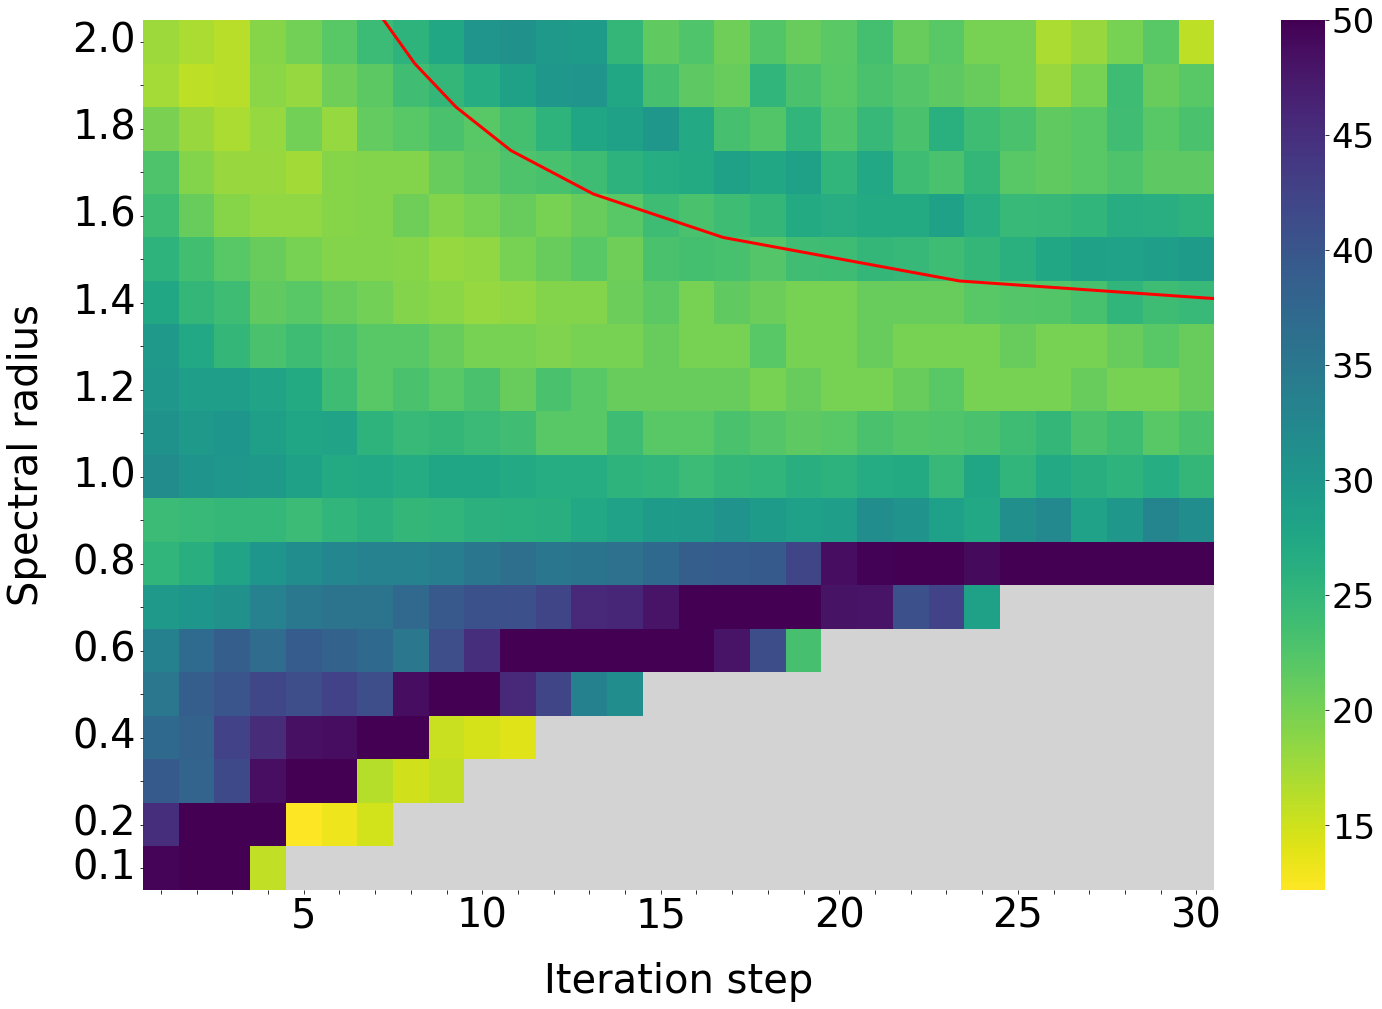

In [29]:
avg_epoch_df = pd.read_csv('./csv/converge_epoch.csv')
avg_epoch_df = avg_epoch_df.set_index(avg_epoch_df.columns[0])

mask = avg_epoch_df == 0
avg_epoch_df[mask] = None

maptype = 'viridis'
plt.rcParams.update({'font.size': 20})
diverging_colors = sns.diverging_palette(220, 20, as_cmap=True)
fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(1, 1, 1)

cmap = sns.color_palette('viridis_r', as_cmap=True)
cmap.set_bad(mcolors.to_rgba('lightgrey'))
g1 = sns.heatmap(avg_epoch_df, cmap=cmap, xticklabels=True, yticklabels=True, ax=ax)
plt.xticks(rotation=0) 
# ax_twin = ax.twinx()

for item in g1.get_xticklabels():
    item.set_rotation(0)
for item in g1.get_yticklabels():
    item.set_rotation(0)

for ind, label in enumerate(g1.get_xticklabels()):
    if (ind + 1) % 5 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
for ind, label in enumerate(g1.get_yticklabels()):
    if (ind) % 2 == 0 or ind==19:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
        
g3 = sns.lineplot(data=lyapunov_time_df, x="Iteration Time", y="Spectral Radius",
                  linestyle="-", linewidth=3, markersize=3, color="red")

# g4 = sns.lineplot(data=nclyapunov_time_df, x="Iteration Time", y="Spectral Radius",
#                   marker="o", linestyle="-", linewidth=2, markersize=3, color="red")

# lyapunov_time = lyapunov_time[::-1]
# for _ in range(9):
#     lyapunov_time = np.append(lyapunov_time, lyapunov_time[-1]*10)

# x = sp_range[::-1]
# for i in range(len(x)):
#     x[i] = x[i] 

# ax_twin.plot(lyapunov_time, x, marker='o', linestyle='-')
        
# g1.set(xlabel="Iteration Step", ylabel="Spectral Radius")        
# # plt.title("MNIST Converging Epoch w.r.t Spectral Radius and Iteration Step", y=-0.12)
# plt.show()
g3.set_xlabel("Iteration step", fontsize=40, labelpad=25)
g3.set_ylabel("Spectral radius", fontsize=40, labelpad=25)
g3.tick_params(axis='both', labelsize=40)
cbar = g3.collections[0].colorbar
cbar.ax.tick_params(labelsize=34)
# plt.title("MNIST Testing Error w.r.t Spectral Radius and Iteration Step", y=-0.12)
# plt.show()
plt.savefig("./figures/MNIST_epoch.eps", format="eps", transparent=True)

In [44]:
avg_epoch_df

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
rho,,,,,,,,,,,,,,,,,,,,,
2.0,17.75,17.00,16.25,19.00,20.25,22.00,24.25,25.50,27.50,30.30,...,23.50,21.00,22.0,20.00,20.00,17.00,18.00,20.00,22.0,16.00
1.9,17.25,16.00,16.25,18.75,18.25,20.50,21.75,23.75,25.00,26.60,...,23.00,22.30,21.6,21.00,20.00,18.00,20.00,24.00,21.0,22.00
1.8,19.75,18.00,17.00,18.25,20.25,18.25,21.25,22.00,23.00,22.00,...,24.75,23.00,26.0,24.00,23.00,21.50,22.00,23.80,22.0,23.00
1.7,22.75,19.25,18.00,18.00,17.50,19.00,19.25,19.25,21.00,21.75,...,27.30,24.00,23.0,25.00,22.00,21.50,22.00,22.70,21.6,21.60
1.6,24.00,21.00,19.00,18.50,18.50,19.00,19.25,20.50,19.25,20.00,...,27.00,27.00,28.3,26.25,24.50,24.75,25.25,26.50,26.3,25.75
1.5,25.50,23.60,22.00,21.00,20.00,19.25,19.25,19.00,18.25,18.50,...,25.00,24.75,24.0,25.00,26.00,27.50,28.30,28.25,29.0,29.25
1.4,27.50,25.00,24.00,21.50,22.00,21.00,20.25,19.25,18.75,18.25,...,21.00,21.00,21.0,22.00,22.25,22.50,23.25,25.25,24.0,24.50
1.3,29.50,27.30,25.00,23.00,24.00,23.00,22.00,22.00,21.00,20.00,...,21.00,20.00,20.0,20.00,21.00,20.00,20.00,21.00,22.0,21.00
1.2,30.00,29.00,29.00,28.00,27.00,24.00,22.00,23.00,22.00,23.00,...,20.00,21.00,22.0,20.00,20.00,20.00,21.00,20.00,20.0,21.00
